In [2]:

!apt-get update -qq
!apt-get install -y -qq tesseract-ocr libtesseract-dev libleptonica-dev

!pip install -q pytesseract opencv-python-headless==4.10.0.84 imutils matplotlib numpy easyocr editdistance


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 11.4 MB/s eta 0:00:00


In [3]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from imutils.object_detection import non_max_suppression
import easyocr
import os
from difflib import SequenceMatcher
import editdistance


def show_image(img, title=''):
    # img can be BGR (cv2) or grayscale
    if len(img.shape) == 3:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_rgb = img
    plt.figure(figsize=(10,6))
    plt.imshow(img_rgb, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


In [4]:

!wget -q --show-progress https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/frozen_east_text_detection.pb -O frozen_east_text_detection.pb


In [7]:

from google.colab import files

print("Upload image files (you can select multiple).")
uploaded = files.upload()



Upload image files (you can select multiple).


Saving images.webp to images.webp


Using: images.webp


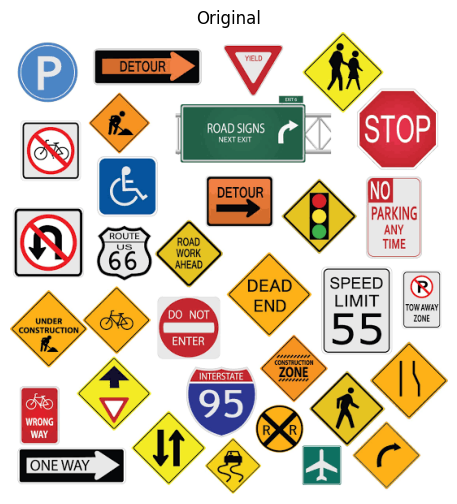

In [8]:
# pick the first uploaded file for demo
img_path = list(uploaded.keys())[0]
print("Using:", img_path)
img = cv2.imread(img_path)
show_image(img, "Original")



In [9]:
# Colab cell (python)
def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def denoise(img_gray):
    # non-local means denoise
    return cv2.fastNlMeansDenoising(img_gray, None, 10, 7, 21)

def adaptive_binarize(img_gray):
    return cv2.adaptiveThreshold(img_gray, 255,
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 25, 10)

def deskew(img_gray):
    coords = np.column_stack(np.where(img_gray > 0))
    if coords.shape[0] == 0:
        return img_gray
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = img_gray.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img_gray, M, (w, h),
                             flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

# quick preprocess pipeline
def preprocess_for_ocr(img):
    gray = to_grayscale(img)
    den = denoise(gray)
    desk = deskew(den)
    bin_img = adaptive_binarize(desk)
    return bin_img


In [10]:
# Colab cell (python)
def decode_predictions(scores, geometry, scoreThresh):
    detections = []
    confidences = []

    (numRows, numCols) = scores.shape[2:4]
    for y in range(0, numRows):
        scoresData = scores[0,0,y]
        x0_data = geometry[0,0,y]
        x1_data = geometry[0,1,y]
        x2_data = geometry[0,2,y]
        x3_data = geometry[0,3,y]
        anglesData = geometry[0,4,y]
        for x in range(0, numCols):
            score = scoresData[x]
            if score < scoreThresh:
                continue

            offsetX = x * 4.0
            offsetY = y * 4.0

            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            endX = int(offsetX + (cos * x1_data[x]) + (sin * x2_data[x]))
            endY = int(offsetY - (sin * x1_data[x]) + (cos * x2_data[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            detections.append((startX, startY, endX, endY))
            confidences.append(float(score))

    return detections, confidences

def east_detect(img, net, min_confidence=0.5, width=1280, height=1280):
    orig = img.copy()
    (H, W) = img.shape[:2]

    # Prepare blob
    newW, newH = (width, height)
    rW = W / float(newW)
    rH = H / float(newH)
    resized = cv2.resize(img, (newW, newH))
    blob = cv2.dnn.blobFromImage(resized, 1.0, (newW, newH),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)

    net.setInput(blob)
    (scores, geometry) = net.forward(["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"])

    rects, confidences = decode_predictions(scores, geometry, min_confidence)
    boxes = []
    for (startX, startY, endX, endY) in rects:
        # scale the coordinates back
        sX = int(startX * rW)
        sY = int(startY * rH)
        eX = int(endX * rW)
        eY = int(endY * rH)
        boxes.append((sX, sY, eX, eY))
    # apply NMS
    rects_np = np.array([[b[0], b[1], b[2], b[3]] for b in boxes])
    if len(rects_np) == 0:
        return []
    picks = non_max_suppression(rects_np, probs=np.array(confidences))
    return picks


In [14]:
!wget -q "https://www.dropbox.com/s/r2ingd0l3zt8hxs/frozen_east_text_detection.tar.gz?dl=1" -O frozen_east_text_detection.tar.gz
!tar -xzf frozen_east_text_detection.tar.gz


In [15]:
import cv2
net = cv2.dnn.readNet("frozen_east_text_detection.pb")
print("EAST model loaded successfully!")

EAST model loaded successfully!


Detected boxes: 39


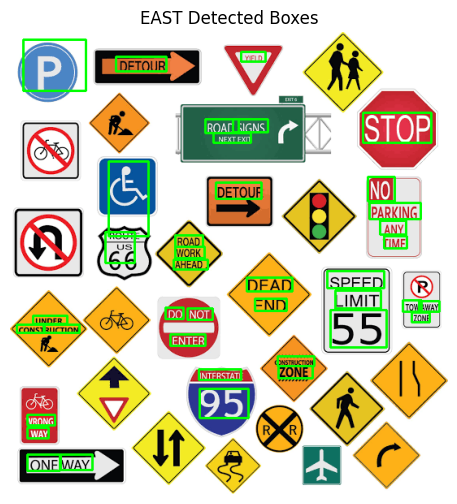

In [16]:
image = img.copy()
boxes = east_detect(image, net, min_confidence=0.5, width=640, height=640)
print("Detected boxes:", len(boxes))

# visualize boxes
vis = image.copy()
for (x1,y1,x2,y2) in boxes:
    cv2.rectangle(vis, (x1,y1), (x2,y2), (0,255,0), 2)
show_image(vis, "EAST Detected Boxes")

Box 0: a=


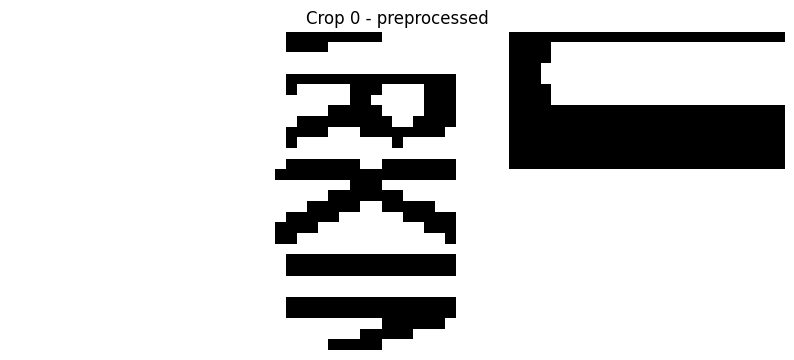

Box 1: 


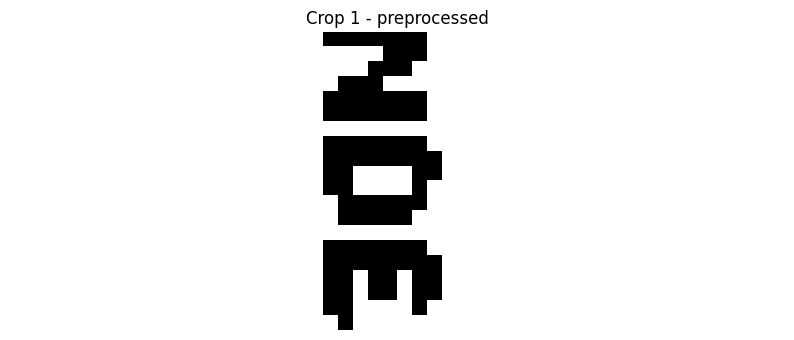

Box 2: 8


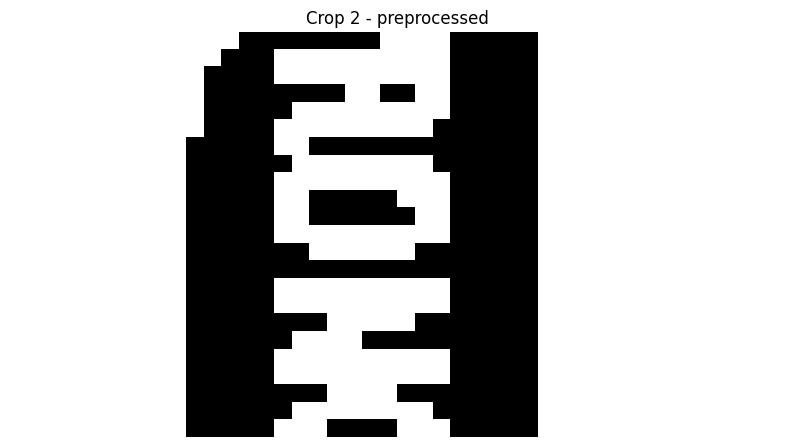

Box 3: fay


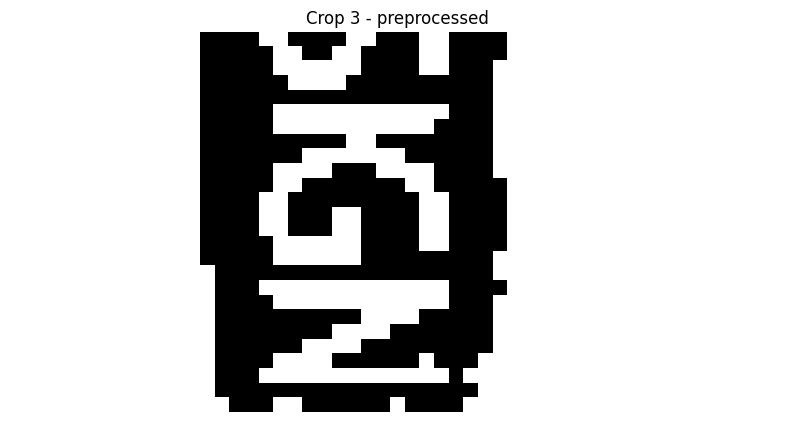

Box 4: iS
Z|


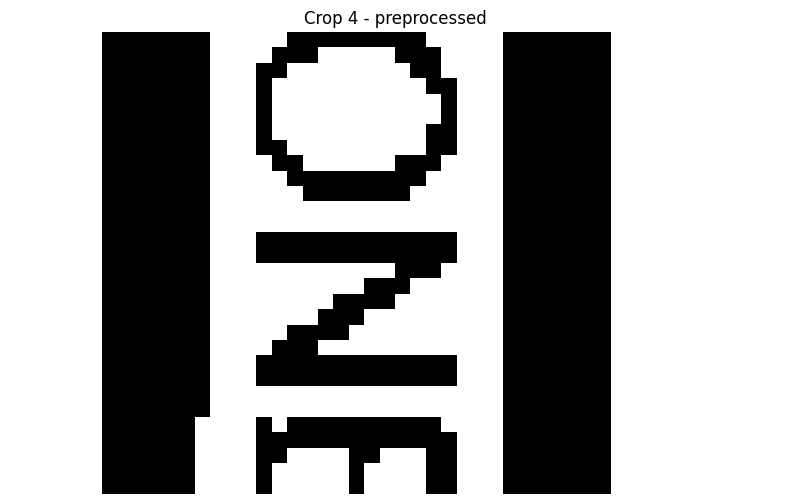

Box 5: SF


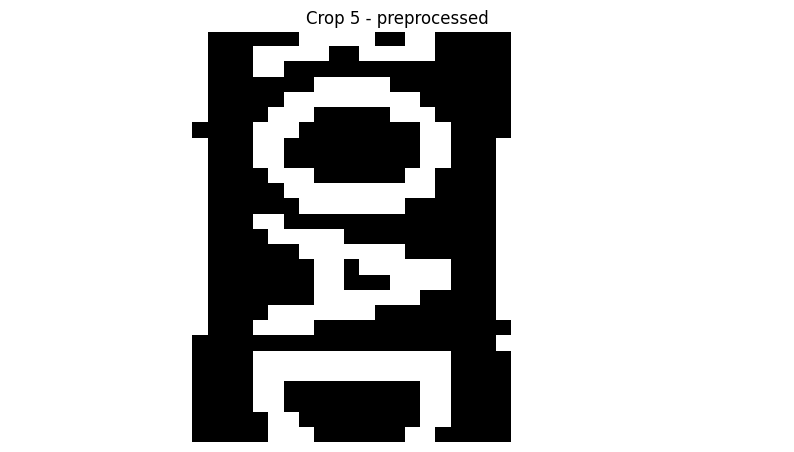

Box 6: 


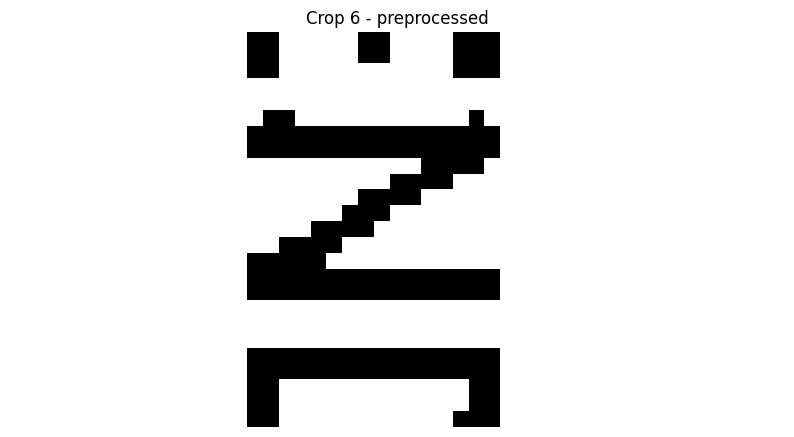

Box 7: m7
A


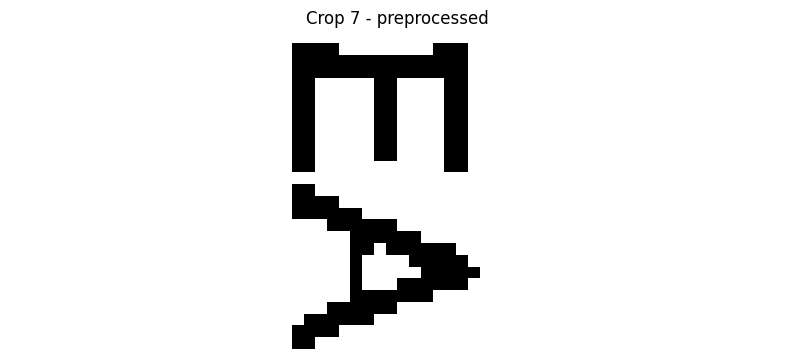

Box 8: iS]


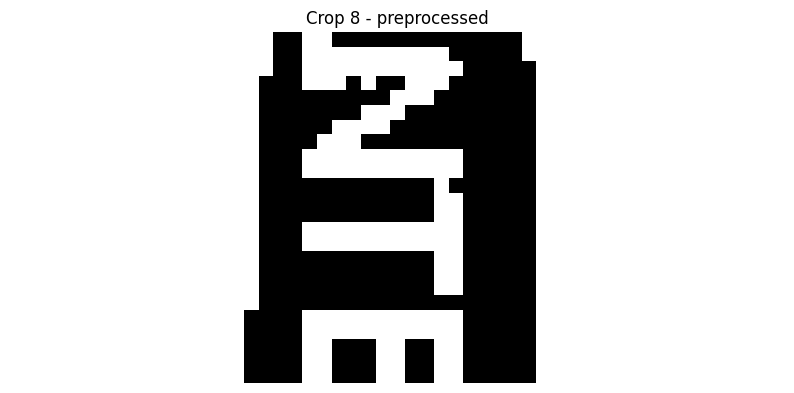

Box 9: 1
m |
m


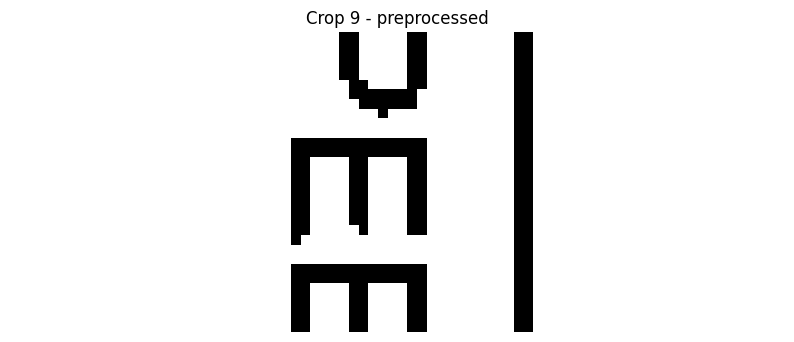

Box 10: a
al


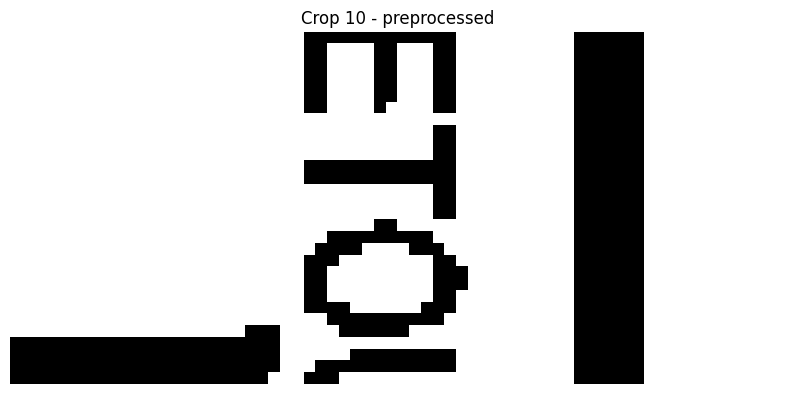

Box 11: fet.


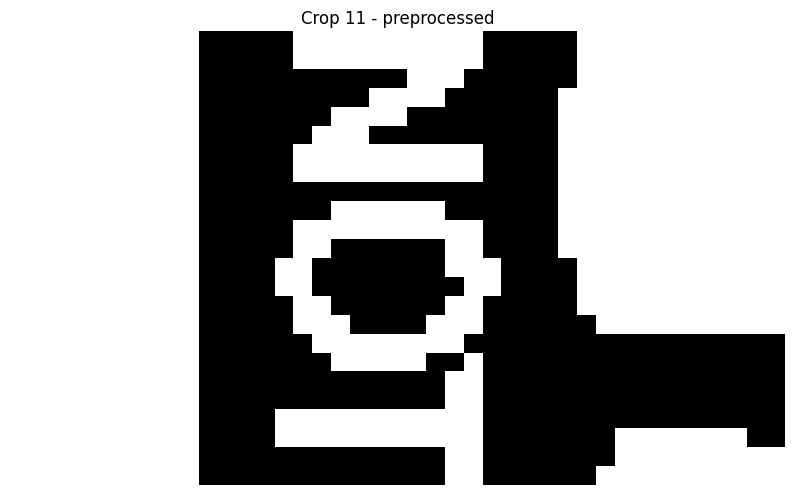

Box 12: oy


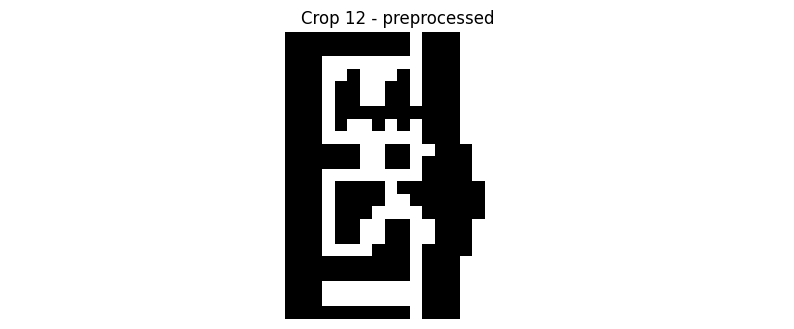

Box 13: Tal


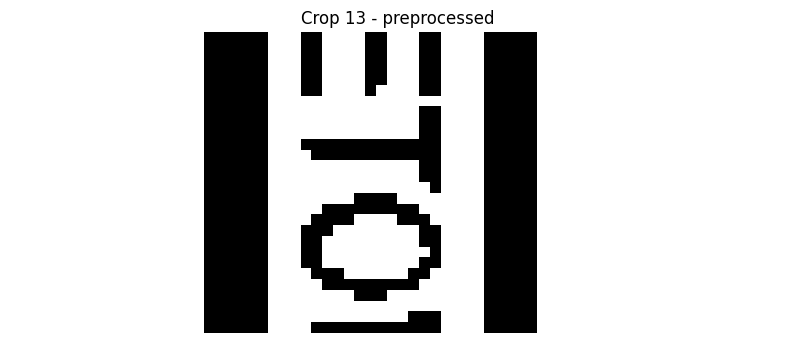

Box 14: ==


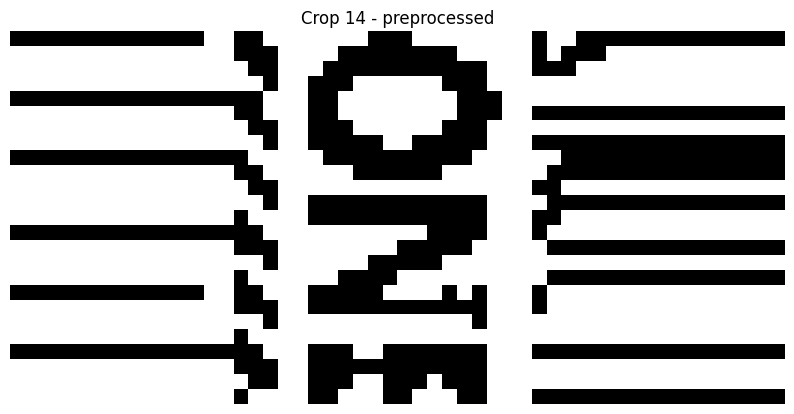

Box 15: 1s]


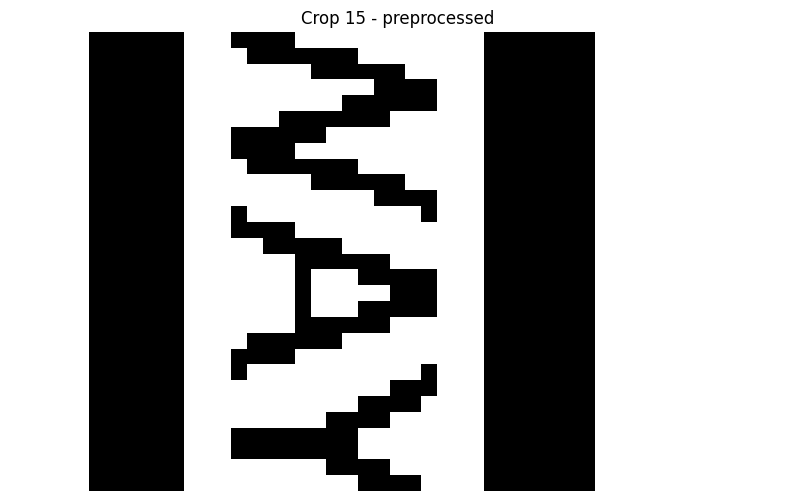

Box 16: E=


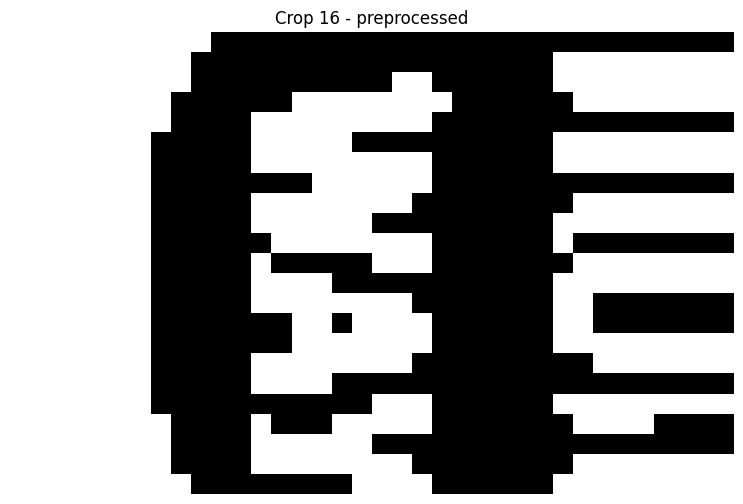

Box 17: =c
—


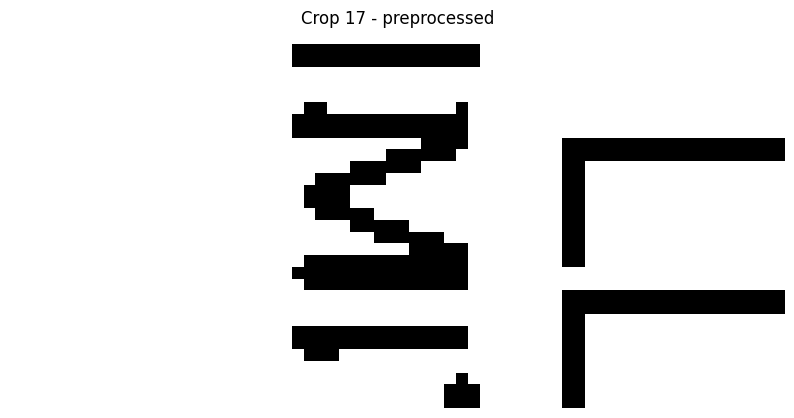

Box 18: (@)


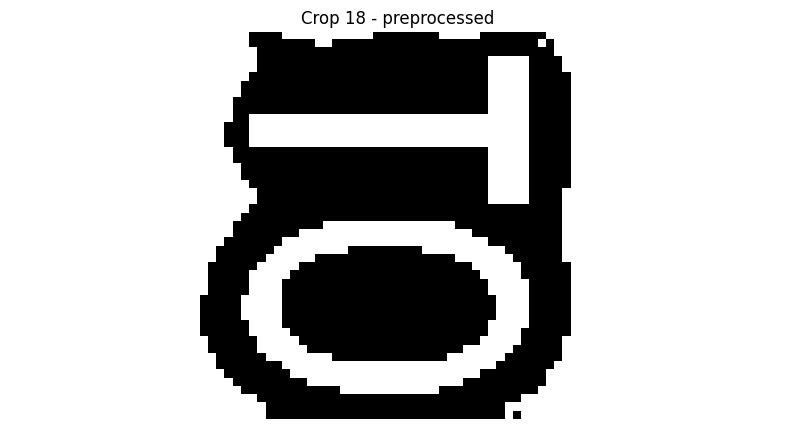

Box 19: >


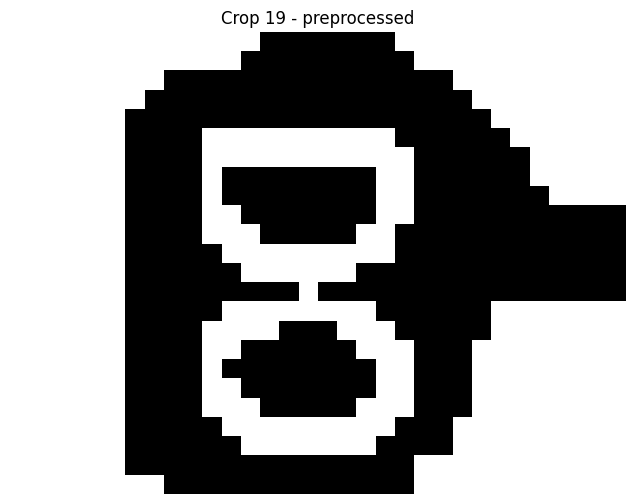

Box 20: q=


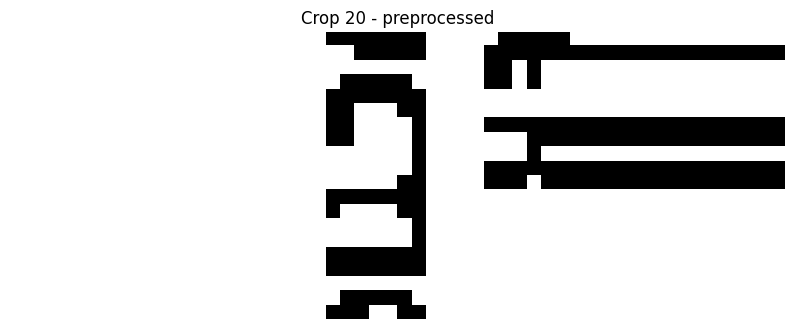

Box 21: 2,


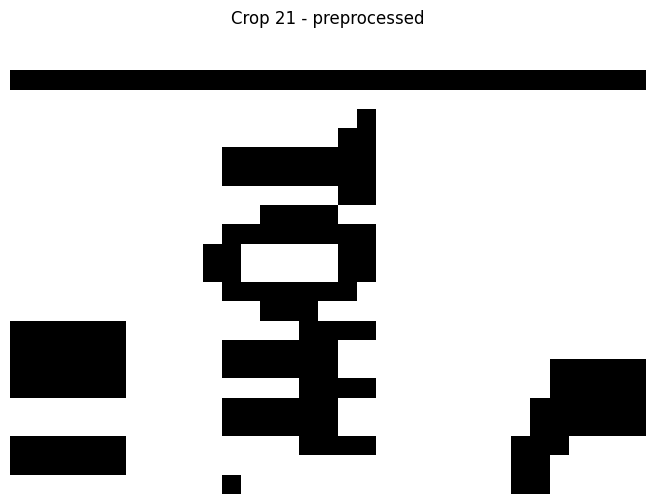

Box 22: = oS
— 2


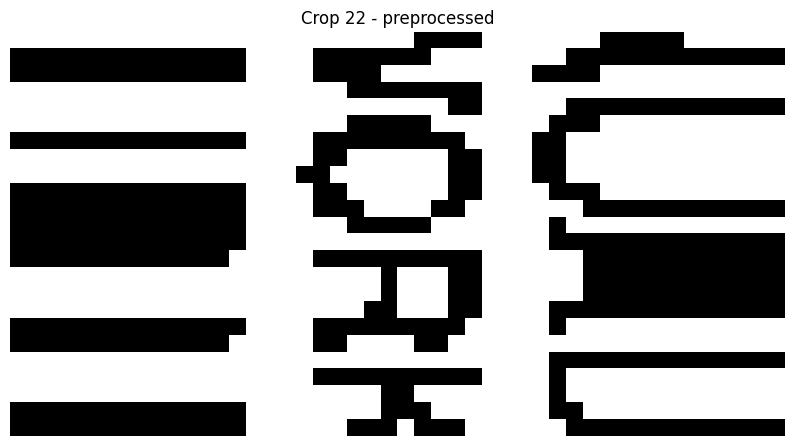

Box 23: So


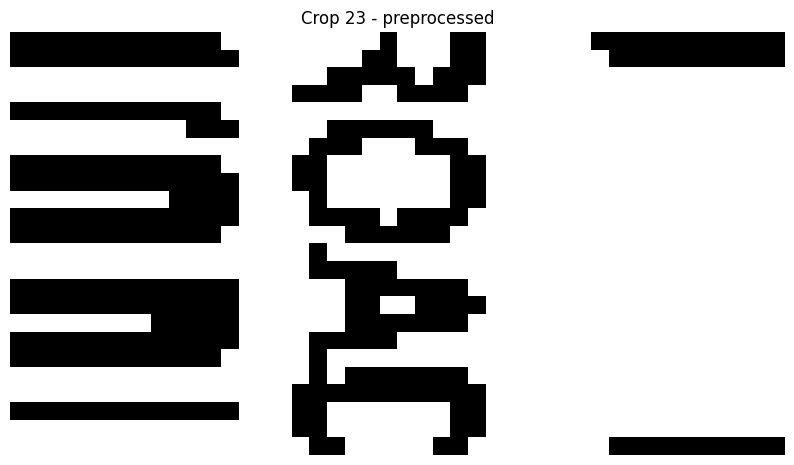

Box 24: 


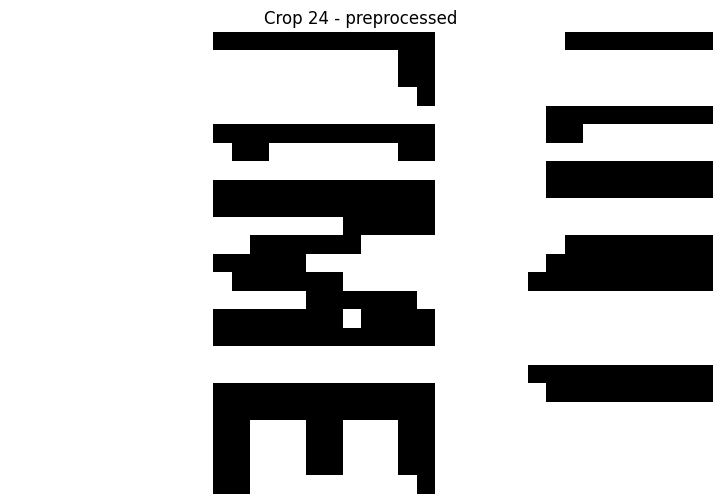

Box 25: B


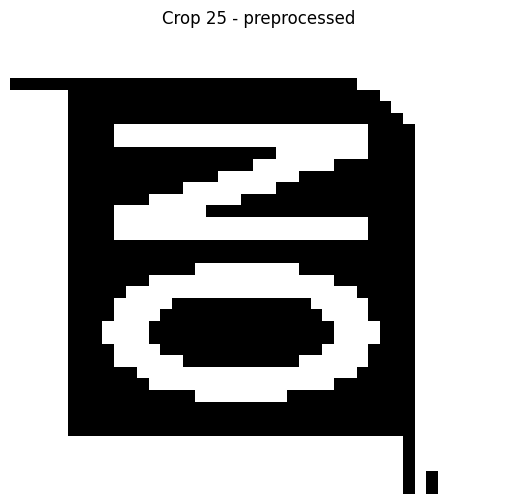

Box 26: wh


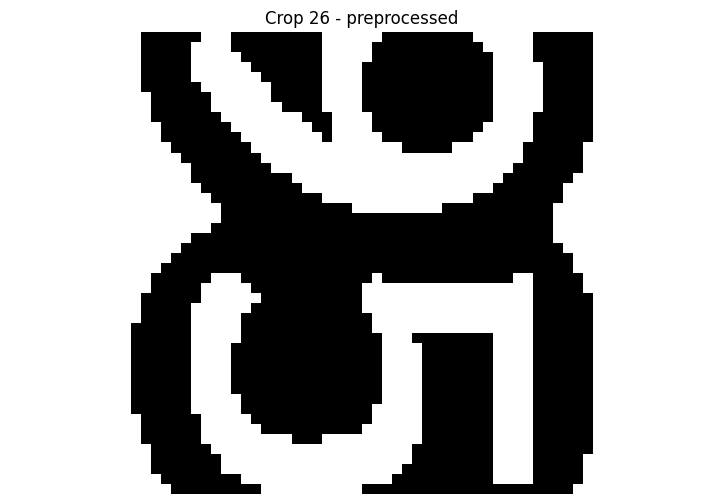

Box 27: ay


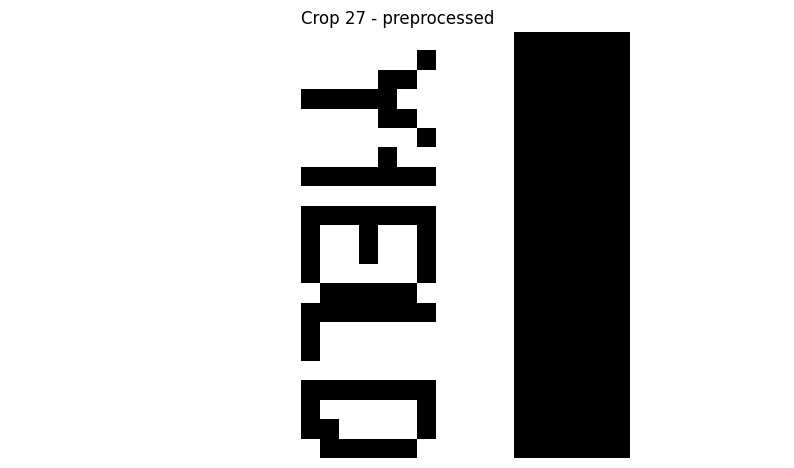

Box 28: 35


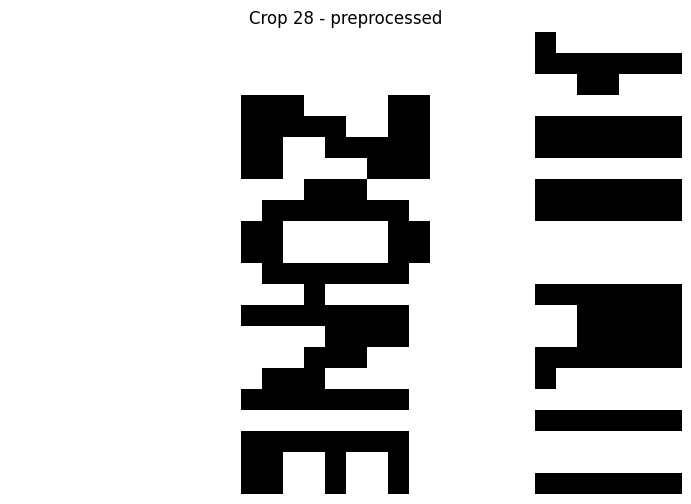

Box 29: =="


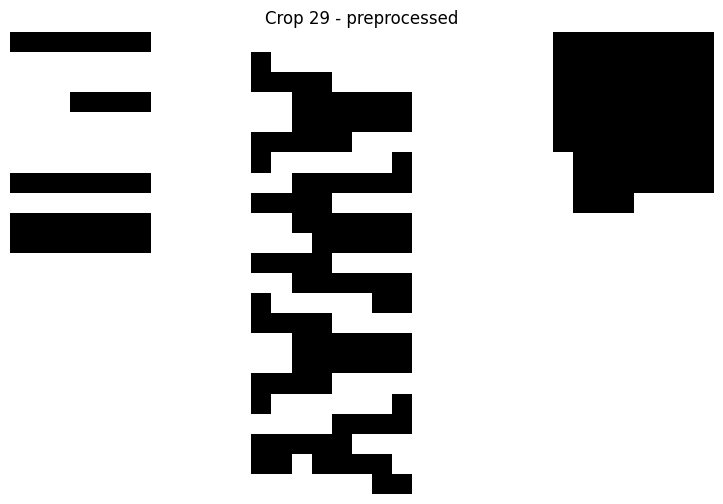

Box 30: 2


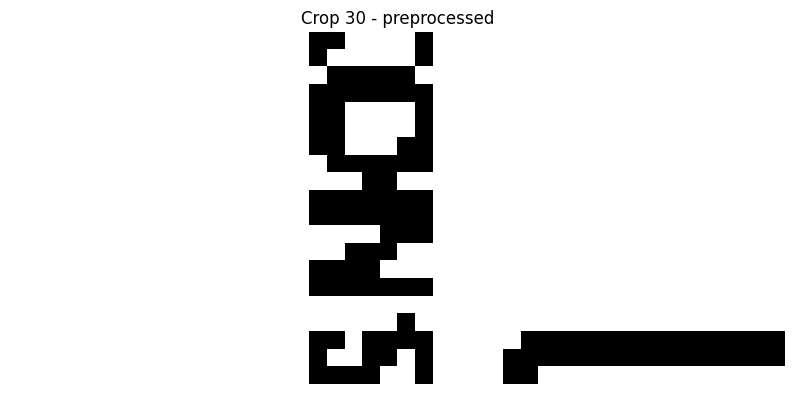

Box 31: 6


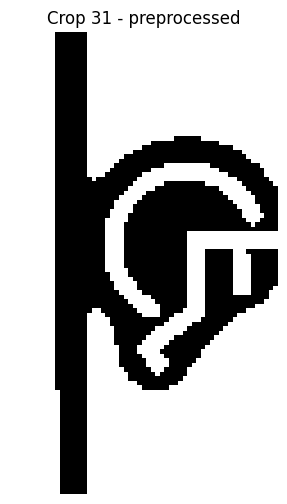

Box 32: —


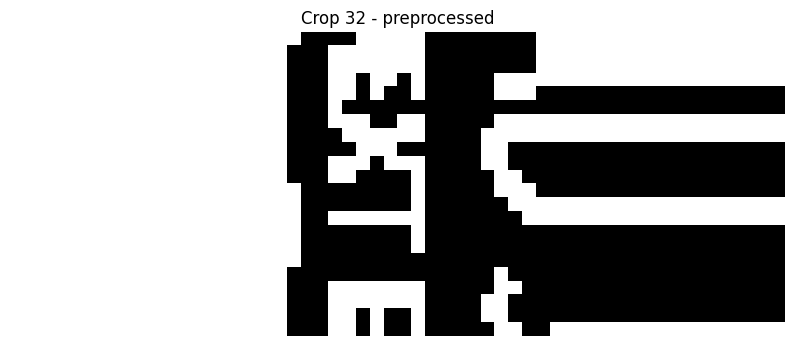

Box 33: 55]


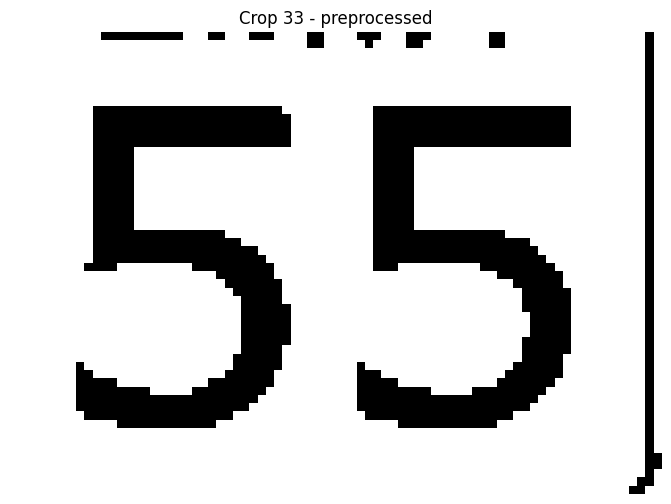

Box 34: ——
BE
z=


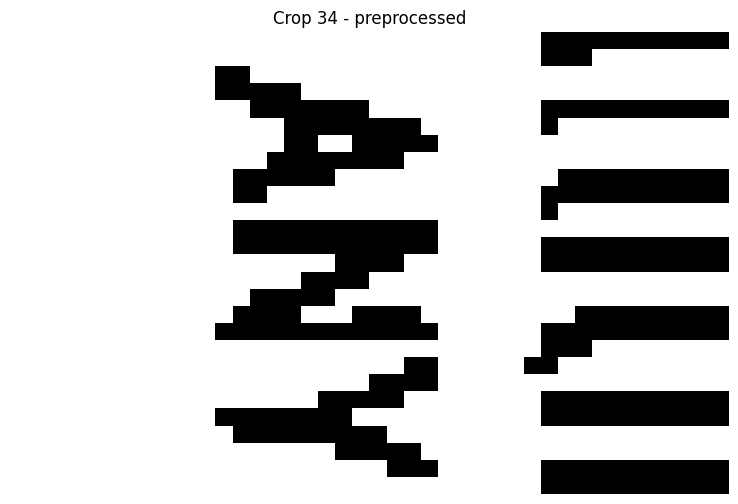

Box 35: i


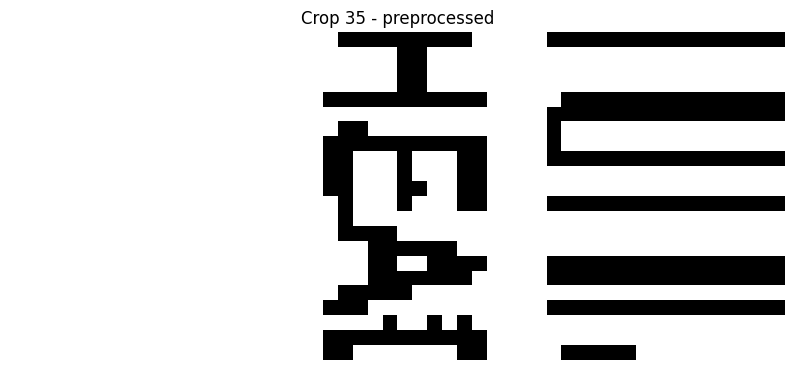

Box 36: y


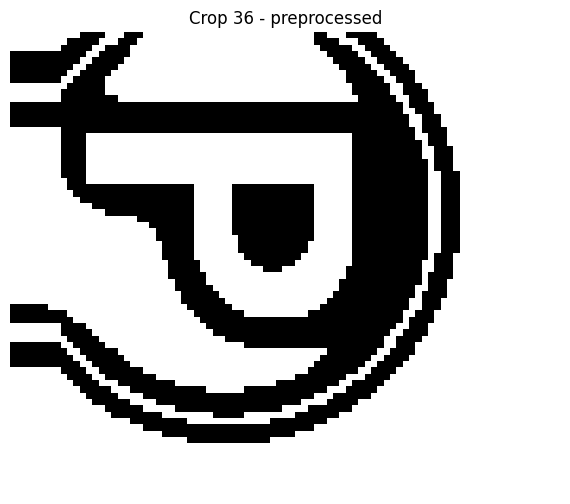

Box 37: —— 25
—iEN


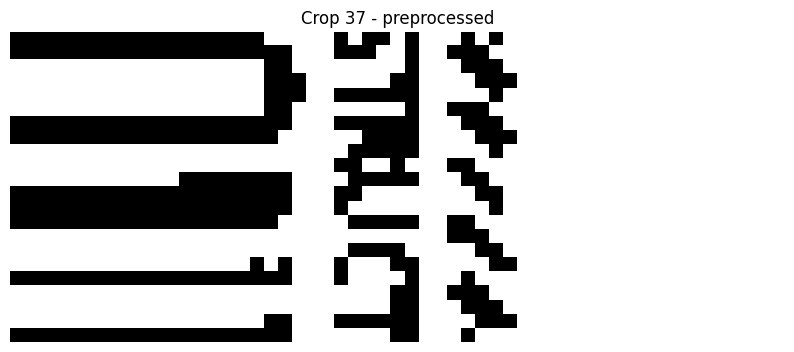

Box 38: Py


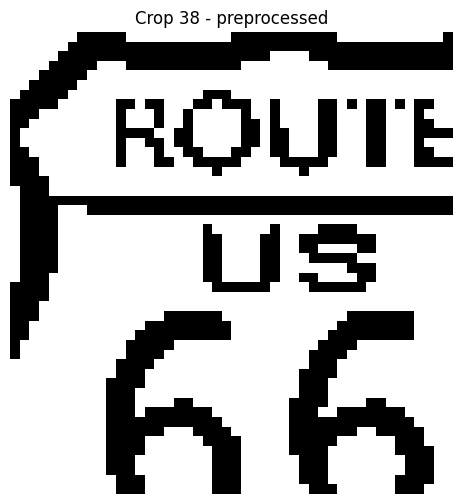

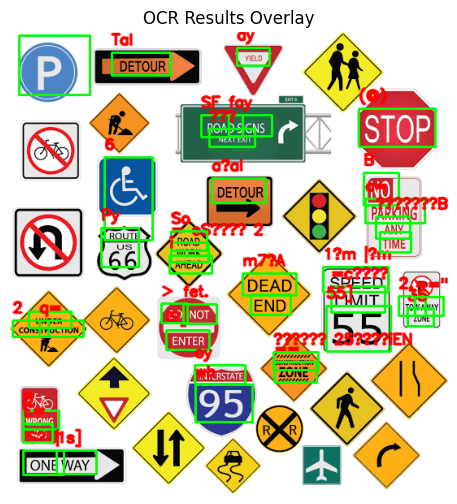

In [17]:

results = []
for i, (x1,y1,x2,y2) in enumerate(boxes):
    # margin/padding
    pad = 5
    sx = max(0, x1-pad); sy = max(0, y1-pad)
    ex = min(image.shape[1], x2+pad); ey = min(image.shape[0], y2+pad)
    roi = image[sy:ey, sx:ex]
    proc = preprocess_for_ocr(roi)
    # Tesseract config: --oem 3 (default LSTM), psm 6 (assume single block of text)
    config = "--oem 3 --psm 6"
    text = pytesseract.image_to_string(proc, config=config)
    text = text.strip()
    results.append({"box":(sx,sy,ex,ey), "text":text})
    # show each result quickly
    print(f"Box {i}: {text}")
    show_image(proc, f"Crop {i} - preprocessed")

# Full overlay of recognized text on image
overlay = image.copy()
for res in results:
    (sx,sy,ex,ey)=res['box']
    cv2.rectangle(overlay, (sx,sy), (ex,ey), (0,255,0), 2)
    cv2.putText(overlay, res['text'][:40], (sx, sy-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2, cv2.LINE_AA)
show_image(overlay, "OCR Results Overlay")


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

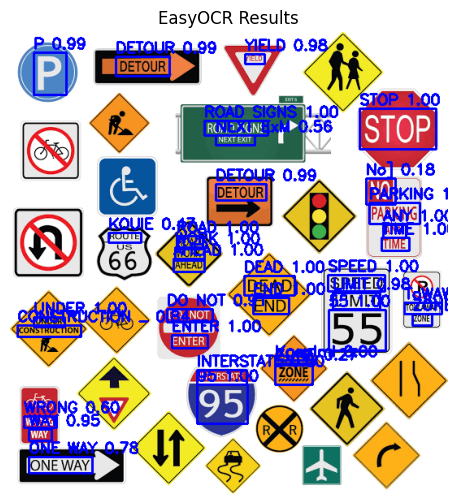

In [18]:

reader = easyocr.Reader(['en'], gpu=False)
results_easy = reader.readtext(img_path)

# show results
overlay2 = image.copy()
for bbox, text, conf in results_easy:
    # bbox is 4 points
    xs = [int(pt[0]) for pt in bbox]
    ys = [int(pt[1]) for pt in bbox]
    x1,y1,x2,y2 = min(xs), min(ys), max(xs), max(ys)
    cv2.rectangle(overlay2, (x1,y1), (x2,y2), (255,0,0), 2)
    cv2.putText(overlay2, f"{text} {conf:.2f}", (x1, y1-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
show_image(overlay2, "EasyOCR Results")


In [19]:
# Colab cell (python)
def iou(boxA, boxB):
    # boxes as (x1,y1,x2,y2)
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA + 1); interH = max(0, yB - yA + 1)
    interArea = interW * interH
    boxAArea = (boxA[2]-boxA[0]+1)*(boxA[3]-boxA[1]+1)
    boxBArea = (boxB[2]-boxB[0]+1)*(boxB[3]-boxB[1]+1)
    denom = float(boxAArea + boxBArea - interArea)
    if denom == 0:
        return 0
    return interArea / denom

def cer(ref, hyp):

    if len(ref) == 0:
        return 1.0 if len(hyp) > 0 else 0.0
    return editdistance.eval(ref, hyp) / float(len(ref))

gt_boxes = [(50,50,200,100)]
gt_texts = ["SAMPLE"]


if len(boxes) > 0:
    print("IoU example:", iou(gt_boxes[0], boxes[0]))
    # compute CER between GT text and detected text (if matched)
    print("CER example:", cer(gt_texts[0], results[0]['text']))


IoU example: 0.0
CER example: 1.0
